# 04 - Meshing and Mesh Quality

In this tutorial, we will discuss how to create a NIRFASTer mesh from scratch: we will start from a 3D volume, create a tetrahedral mesh using the volume, convert it to the NIRFASTer format, and add optodes to it. We will also look at how the mesh quality may affect the quality of your results.

The idea for this pipeline is that when you have access to a segmented volume (e.g. the structural MRI of a human head), some prior knowledge of the optical properties, together with optode locations, you can quickly create a model for it, and generate some forward data or perform DOT reconstruction. This is enabled by incorporating a [CGAL mesher](https://www.cgal.org/) in the package. The same mesher is also the meshing engine of the older Matlab-based NIRFAST(er) toolboxes, and iso2mesh.

In this tutorial, we will focus on a 2-layer slab model, and use only the standard mesh type. We will move to a human head model in the next tutorial.

In [1]:
import sys
sys.path.insert(1, '../')
import nirfasterff as ff # ff is short for fast and furious
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a volume, make sure it's in uint8
vol = 2 * np.ones((60,60,50))
vol[:,:,:15] = 1 # different regions labeled in different integers
vol = vol.astype(np.uint8)

Starting from here, there are two ways to create a NIRFASTer mesh: 1) call the mesher, and the then construct a nirfasterff.base.stndmesh object, or 2) use a one-liner wrapper to directly construct the nirfasterff.base.stndmesh object. Internally, they are *exactly* the same, but the first version gives you the possibility of checking the mesh quality in the middle or use an external mesher, where as the second makes your code more compact.

Let's start with the first method, and use the default parameters.

In [4]:
# call the mesher
ele, nodes = ff.meshing.RunCGALMeshGenerator(vol)
# run the quality check
ff.meshing.CheckMesh3D(ele, nodes)

Meshing...

Running Lloyd smoothing... (up to 120s)

Running local optimization...

Checking solid mesh:
Avg Min Max volume: 6.200932 1.094077 11.561754

Avg Min Max volume ratio quality: 0.755723 0.208419 0.935129

Checking tetrahedral faces..... 
Done
----> Checking integrity of the surface of the solid mesh...
Checking surface mesh:
----> Done.


(array([5.82752124, 8.55564409, 6.38937811, ..., 7.07213948, 5.63138731,
        8.24497266]),
 array([0.70073254, 0.85836082, 0.86705689, ..., 0.8437031 , 0.64973368,
        0.6702741 ]),
 0.0,
 0,
 0)

A few notes: 1) the default parameters assume that the resolution of the volume is 1mm in all dimensions, 2) Lloyd smoothing is by default enabled for better quality mesh, but can take up to 120s (hard stop implemented to avoid prolonged meshing time), 3) we can save the results of the mesh quality check for further investigation, but in general we only need to read the printed message and spot any reported errors.

Now let's construct a standard NIRFASTer mesh. It will complain that some necessary information is missing, but that's OK. This is just a reminder and we will deal with them later.

(<Figure size 640x480 with 2 Axes>, <Axes3D: >)

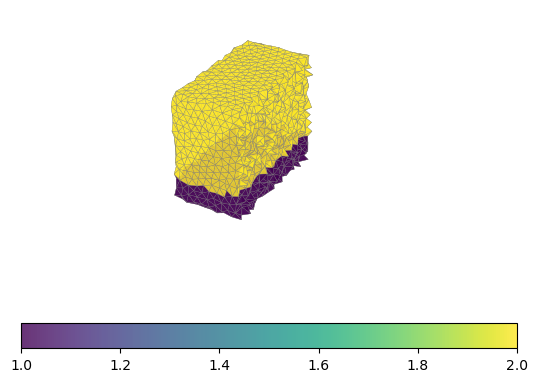

In [5]:
mesh = ff.base.stndmesh()
mesh.from_solid(ele, nodes)
# have a look
ff.visualize.plot3dmesh(mesh, mesh.region, 'x<30')

That's good. Now let's set the optical properties and add a pair of source and detector. You can of course directly modify the attributes of the mesh directly, but it is recommended to use the set property function.

In [7]:
# optical properties, similar to the MCX format
# for each row, [region, mua(mm-1), musp(mm-1), ri]
prop = np.array([[1, 0.0190, 0.64, 1.33],
                [2, 0.0208, 1.0107, 1.33]])
mesh.set_prop(prop)
# set link (source-detector pairs)
mesh.link = np.atleast_2d([1,1,1]) # make sure it's a n x 3 matrix
# optodes
mesh.source = ff.base.optode(np.array([20,30,0]))
mesh.meas = ff.base.optode(np.array([40,30,0]))
# move them (for non-fixed) and calculate the integration function
mesh.touch_optodes()

touching sources
touching detectors


We now have a newly created stndmesh. Let's generate some data with it

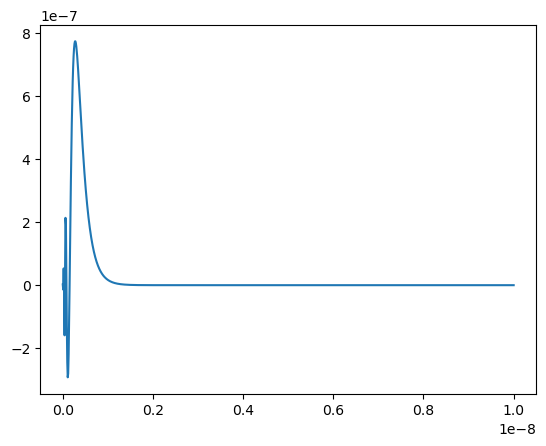

In [9]:
tpsf1 = mesh.femdata_tpsf(10e-9, 1e-11, beautify=False)[0] # don't remove the initial unstable parts
# plot it
plt.plot(tpsf1.time, tpsf1.tpsf[0,:])
plt.show()

That does not look too great, noticing the initial oscillations in the curve. Indeed, the "beautify" switch is by default turned on and they will be removed in the result, it is still undesirable to have oscillations this dramatic. In fact, if you are curious and compare the moments calculated using the TPSF and the moments calculated using the direct solver, you will see a mismatch (recall what we did in the first tutorial).

This is because of the mesh being too coarse, an issue that the current version mesh quality checker cannot detect, unfortunately. We do need our mesh to be plenty dense for numerical accuracy, and the TPSF is a good example of how insufficient density can impact the results. 

Let's now repeat the procedure and make a denser mesh, and see if there is improvement. We will be using the one-liner version this time.

In [11]:
# meshing parameter, different cell size for different regions
params = ff.utils.MeshingParams()
params.subdomain = np.array([[1, 1],[2, 1.5]]) # cell size 1 for region 1, cell size 1.5 for region2
# if there are other regions and not specified in subdomain, the general_cell_size will be used, which is 3 by default
sources = ff.base.optode(np.array([20,30,0]))
detectors = ff.base.optode(np.array([40,30,0]))
link = np.atleast_2d([1,1]) # if the third column is missing, automatically assumed to be all 1
# now mesh
mesh = ff.base.stndmesh()
mesh.from_volume(vol, params, prop=prop, src=sources, det=detectors, link=link)

Running CGAL mesher
Meshing...

Running Lloyd smoothing... (up to 120s)

Running local optimization...

Converting to NIRFAST format


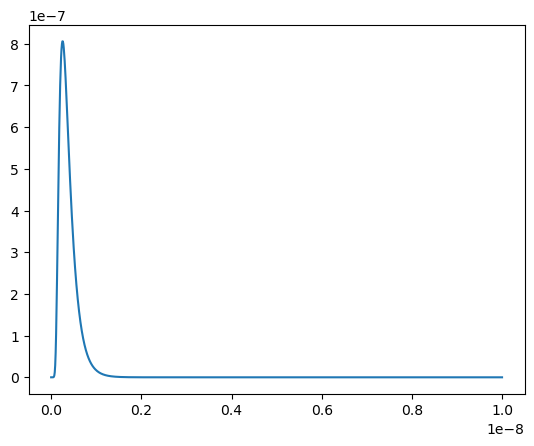

In [12]:
tpsf2 = mesh.femdata_tpsf(10e-9, 1e-11, beautify=False)[0] # don't remove the initial unstable parts
# plot it
plt.plot(tpsf2.time, tpsf2.tpsf[0,:])
plt.show()

That's much better. Once you're happy with the mesh, you can save it to the classic NIRFASTer files for later use, either in Python or Matlab.

In [13]:
mesh.save_nirfast('myslab')

This concludes the meshing tutorial. You should now understand how to construct a NIRFASTer mesh from a segmented volume, and how mesh quality can affect your results.

In the next tutorial, we will do some very similar things, but in a more realistic setting: the human brain.